### 1. Inicie o ambiente


In [1]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 81kB 5.9MB/s ta 0:00:011
    100% |████████████████████████████████| 60.7MB 781kB/s eta 0:00:01    17% |█████▋                          | 10.6MB 46.8MB/s eta 0:00:02
    100% |████████████████████████████████| 6.4MB 10.8MB/s ta 0:00:01
    100% |████████████████████████████████| 8.8MB 5.7MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 18.7MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 29.7MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 25.2MB/s ta 0:00:01
    100% |████████████████████████████████| 378kB 26.6MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 18.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /root/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.26 which is incompatib

In [2]:
import time
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from agent import Agent
%matplotlib inline

plt.style.use('ggplot')

In [3]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# obtenha o cérebro padrão
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examinando o Estado e os Espaços de Ação

In [5]:
# redefinir ambiente
env_info = env.reset(train_mode=True)[brain_name]

# número de agentes no ambiente
print('Number of agents:', len(env_info.agents))

# número de ações
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examina o espaço de estados
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Start training

In [6]:
def dqn(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Q-Learning Profundo.
    
    parâmetros
    ======
        n_episodes (int): número máximo de episódios de treinamento
        max_t (int): número máximo de timesteps por episódio
        eps_start (float): valor inicial epsilon, para seleção de ação epsilon-greedy
        eps_end (float): valor epsilon mínimo
        eps_decay (float): fator multiplicativo (por episódio) para diminuir epsilon
    """
    scores = []                        # lista contendo pontuações para cada episódio
    scores_window = deque(maxlen=100)  # últimas 100 pontuações
    eps = eps_start                    # inicializar epsilon
    for i_episode in range(1, n_episodes+1): # loop de episódios
        env_info = env.reset(train_mode=True)[brain_name] # reiniciar o ambiente
        state = env_info.vector_observations[0]           # obter o estado inicial
        score = 0                                        # inicializar a pontuação
        for t in range(max_t): # loop de timesteps
            action = agent.act(state, eps) # escolher uma ação
            env_info = env.step(action)[brain_name]       # enviar a ação ao ambiente
            next_state = env_info.vector_observations[0] # obter o próximo estado
            reward = env_info.rewards[0]                # obter a recompensa
            done = env_info.local_done[0]             # verificar se o episódio terminou
            agent.step(state, action, reward, next_state, done) # passar para o agente
            state = next_state # passar o próximo estado para o estado atual
            score += reward # atualizar a pontuação
            if done:
                break 
        scores_window.append(score)       # salva a pontuação mais recente
        scores.append(score)              # salva a pontuação mais recente
        eps = max(eps_end, eps_decay*eps) # diminuir epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores 

agent = Agent(state_size=37, action_size=4, seed=0)
scores = dqn(env, agent)

Episode 100	Average Score: 1.28
Episode 200	Average Score: 4.81
Episode 300	Average Score: 8.48
Episode 400	Average Score: 10.64
Episode 467	Average Score: 13.01
Environment solved in 367 episodes!	Average Score: 13.01


### 4. Plot the scores

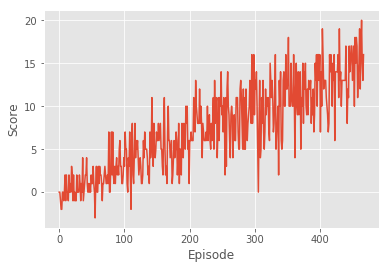

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### 5. Test the agent

In [8]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))


env_info = env.reset(train_mode=False)[brain_name]  # redefinir ambiente
state = env_info.vector_observations[0]             # obtém o estado atual
score = 0                                           # inicializa a pontuação

while True:
    action = agent.act(state)                      # selecione uma ação
    env_info = env.step(action)[brain_name]        # envia a action para o ambiente
    reward, next_state, done = env_info.rewards[0], env_info.vector_observations[0], env_info.local_done[0]
    
    score += reward                                # pontuação de atualização
    state = next_state                             # rola o estado para o próximo passo de tempo
    if done:                                       # loop de saída se o episódio terminou
        break
    
print("Score: {}".format(score))

Score: 10.0


In [9]:
env.close()